# Looking at the goodness of fit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sncosmo
from bayesn import SEDmodel
import os
import pandas as pd
import pickle

## Make a list of SN

In [2]:
directory = os.fsencode("/root/partiiiproject/Archive")
supernovae_names = ["sn2009I"]
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".dat"): 
        supernovae_names.append(filename[:-4])
        continue
    else:
        continue

## Load the W22 Model

W22 model works with optical and NIR bands

In [3]:
filter_yaml = "/root/partiiiproject/bayesn-filters/bayesn-filters/filters.yaml"
model = SEDmodel(load_model='W22_model', filter_yaml = filter_yaml)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Current devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]
Currently working in /root/partiiiproject
Loading built-in model W22_model
Loading built-in reddening law F99


## Define which SN we are looking at and which bands

In [4]:
supernova_name = "sn2014J"
dust_law = "F99"
supernova_file = "/root/partiiiproject/Archive/"+supernova_name+".dat"


## Load Observational Data

We read the observational data and its assosciated uncertainty 

In [5]:
meta, lcdata = sncosmo.read_snana_ascii(supernova_file, default_tablename='OBS')
lcdata = lcdata['OBS'].to_pandas()

## Use chains to get Fits to plot

Choose the bands we want to plot and the number of days on either side of the peak.

In [6]:
t = np.arange(-5, 20, 1)
t_obs = lcdata['MJD'] - meta['SEARCH_PEAKMJD']
bands = np.unique(lcdata['FLT']) #['g_CSP', 'r_CSP', 'i_CSP', 'B_CSP', 'V_CSP', 'Y_RC', 'J_RC1', 'H_RC']
z = meta['REDSHIFT_FINAL']
ebv_mw = meta['MWEBV']

sampleChainsDir = "DustLawsFitOfAllSamples/"+supernova_name + dust_law + "_chains.pkl"
sampleSummaryDir = "DustLawsFitOfAllSamples/"+supernova_name + dust_law + "_fit_summary.csv"

samplesSummary = pd.read_csv(sampleSummaryDir)
samplesSummary = samplesSummary.rename(index=samplesSummary['Unnamed: 0'])

t_obs = np.unique(t_obs)

In [7]:
with open(sampleChainsDir, 'rb') as file:
    chains = pickle.load(file)

## Simulate Light Curves using parameters from fit

In this method we just use the get flux from chains with observed t

## Compare Simulation and fitted light curve

In [8]:
#flux_grid = model.get_flux_from_chains(t, bands, sampleChainsDir, z, ebv_mw, mag=False, num_samples=10)
#fit, fit_err = flux_grid.mean(axis=(0, 1)), flux_grid.std(axis=(0, 1))

t = t_obs
flux_grid = model.get_flux_from_chains(t, bands, sampleChainsDir, z, ebv_mw, mag=False, num_samples=10)
fit, fit_err = flux_grid.mean(axis=(0, 1)), flux_grid.std(axis=(0, 1))
print(fit.shape)
print(t.shape)

Getting best fit light curves from chains...


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.99s/it]

(25, 636)
(636,)


## Plot Graphs

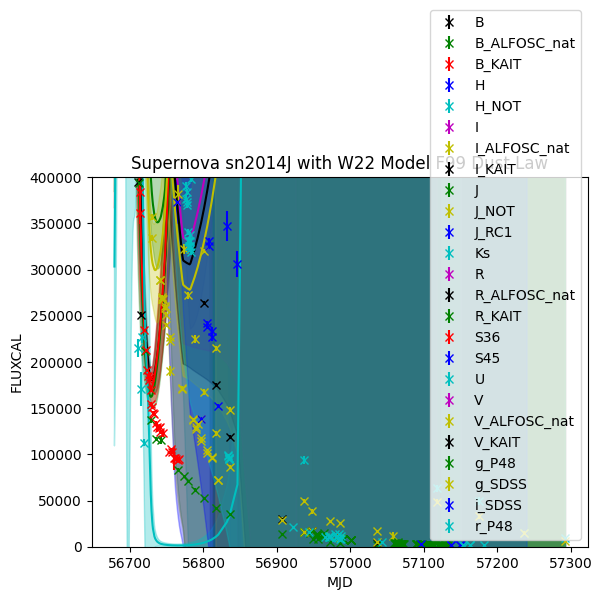

In [14]:
cs = ['k','g', 'r', 'b', 'c', 'm', 'y', 'k','g', 'y', 'b', 'c', 'm','k','g', 'r', 'b', 'c', 'm', 'y', 'k','g', 'y', 'b', 'c', 'm']
plot_t = t + meta['SEARCH_PEAKMJD']


for b_ind, b in enumerate(bands):

    #Observed
    b_data = lcdata[lcdata.FLT == b]
    plt.errorbar(b_data.MJD, b_data.FLUXCAL, b_data.FLUXCALERR, fmt=f'{cs[b_ind]}x', label=b)

    #From fit
    plt.plot(plot_t, fit[b_ind, :], color=cs[b_ind])
    #plt.fill_between(plot_t, fit[b_ind, :] - fit_err[b_ind, :], fit[b_ind, :] + fit_err[b_ind, :], alpha=0.3, color=cs[b_ind])

    #From simulation 
    #plt.plot(t_obs+meta['SEARCH_PEAKMJD'], flux[b_ind,:], color=cs[b_ind], linestyle='dotted')
   
plt.title(rf'Supernova '+supernova_name+' with W22 Model ' + dust_law +' Dust Law')
plt.xlabel('MJD')
plt.ylabel('FLUXCAL')
plt.ylim(0,400000)
plt.legend()
#plt.figtext(0.5, .8, rf"Mean $A_v$ =  {np.mean(samples['AV']):.2f}")
#plt.figtext(0.5, .75, rf"Std $A_v$ =  {np.std(samples['AV']):.2f}")
#plt.figtext(0.5, .7, rf"Mean $R_v$ =  {np.mean(samples['RV']):.2f}")
#plt.figtext(0.5, .65, rf"Std $A_v$ =  {np.std(samples['RV']):.2f}")
#plt.savefig("/root/partiiiproject/DustLawsGeneralGraphs/simulation"+supernova_name+dust_law+".png", bbox_inches='tight') 
plt.show()

## Chi squared error

In [ ]:
"""chi_squared = np.zeros(len(lcdata))
for i, entry in lcdata.iterrows():
    if entry.FLT == 'u_csp':
        continue
    index_t_obs = np.where(t_obs == (entry.MJD-meta['SEARCH_PEAKMJD']))
    index_band = np.where(bands == entry.FLT)
    Exp = flux[index_band, index_t_obs]
    Obs = entry.FLUXCAL
    chi_squared[i] = ((Obs-Exp)**2)/Exp"""

chi_squared = np.zeros(len(lcdata))
for i, entry in lcdata.iterrows():
    if entry.FLT == 'u_CSP':
        continue
    index_t_obs = np.where(t == (entry.MJD-meta['SEARCH_PEAKMJD']))
    index_band = np.where(bands == entry.FLT)
    Exp = fit[index_band, index_t_obs]
    Exp = Exp[0]
    Obs = entry.FLUXCAL
    ObsErr = entry.FLUXCALERR
    chi_squared_calc = ((Obs-Exp)**2)/(ObsErr**2)
    chi_squared[i] = chi_squared_calc[0]
    if entry.FLT == 'r_CSP':
        print(entry.MJD-meta['SEARCH_PEAKMJD'])


In [ ]:
print(np.mean(chi_squared))
print(z)

## Plot Chi Squared for bands

In [ ]:
figure, axis = plt.subplots(1+len(bands)//2, 2) #Sub plots 3 rows and 2 columns
for b_ind, b in enumerate(bands): #Loop through the bands given
    b_data = lcdata[lcdata.FLT == b] #get the original data for the band (previous method took first character!)
    indexes_for_bands = lcdata.index[lcdata.FLT == b].tolist()
    axis[b_ind//2, b_ind%2].plot(b_data.MJD, chi_squared[indexes_for_bands], color=cs[b_ind])
    axis[b_ind//2, b_ind%2].set_title(b)
    axis[b_ind//2, b_ind%2].set_xlabel('MJD')
    axis[b_ind//2, b_ind%2].set_ylabel('Chi Squared')
#axis.legend()
plt.subplots_adjust(left=0, right=3, bottom=0, top=3, wspace=0.2, hspace=0.4)
figure.show()